# Processing and Understanding Text - Dipanjan Sarkar

My effort to grok NLP enough to figure out what I need for my tasks. This is part of my mid-up approach (bottom being HMMs etc) to learning NLP. I am also going top-down in trying to understand how to do the tasks in ChatGPT and others. For now the focus is on actually trying to figure out what `nlp task` or combinations of `nlp tasks` covers my requirements so I can get started building a prototype.

## References
 - [A Practitioner's guide to NLP - 2018](./AI/NLP/pdfs/A%20Practitioner's%20Guide%20to%20Natural%20Language%20Processing%20(Part%20I)%20%E2%80%94%20Processing%20%26%20Understanding%20Text%20_%20by%20Dipanjan%20Sarkar.pdf). _This is an old doc but has so much classical NLP references that I think it a must to understand it_

# Downloading test data from the web


There are many corpora available in various sizes. Dipanjan wants to use a small/current dataset by scraping a news summarization site.

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import spacy
from spacy import displacy

%matplotlib inline

%load_ext nb_js_diagrammers
import iplantuml

import sys
sys.path.append("../../python/")

The nb_js_diagrammers extension is already loaded. To reload it, use:
  %reload_ext nb_js_diagrammers


In [5]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Intel urges you to improve business performanc...,Intel shared that Intel vPro has demonstrated ...,technology
1,Challenge is on: Tech Mahindra CEO after OpenA...,"Tech Mahindra's MD & CEO CP Gurnani tweeted, ""...",technology
2,I think it is for Jack Dorsey to clarify why h...,Commenting on Jack Dorsey's claim that the Ind...,technology
3,Be mindful of wearing Reddit gear in public: C...,Reddit CEO Steve Huffman sent an e-mail to the...,technology
4,"Accenture to invest $3 bn in AI, double AI tal...",Accenture is set to invest $3 billion in AI ov...,technology
5,Realme Vice President Madhav Sheth quits compa...,"Madhav Sheth, Realme Vice President and Presid...",technology
6,Google to track employee badges to ensure work...,"Google has updated its hybrid working policy, ...",technology
7,"Many women quit TCS, HR cites work-from-office...",TCS is witnessing a higher attrition rate amon...,technology
8,US judge temporarily blocks Microsoft's $69-bi...,A judge has granted a request by regulators in...,technology
9,"Googlers left the company to create over 2,000...","Google CEO Sundar Pichai told Bloomberg, ""Goog...",technology


In [6]:
# Check the number of articles we have available
news_df.news_category.value_counts()

news_category
technology    25
sports        25
world         24
Name: count, dtype: int64

# Text wrangling and pre-processing step

These **pre-processing** steps were covered in more detail in the [NLP_PreProcessing notebook](./NLP_PreProcessing.ipynb), read that if you want to recap the motivation behind all the pre-processing. The code developed in that notebook is simply copied over here.

In [7]:
import spacy
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import contractions
import unicodedata
import matplotlib.pyplot as plt

# Download stop words if not installed already. 
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stops = stopwords.words('english')
stops_set = set(stops)
stops_set.remove('no')   # ??
stops_set.remove('not')  # ??

tokenizer = ToktokTokenizer()

# old: nlp = spacy.load('en', parse = False, tag=False, entity=False)
# Download model first using
nlp = spacy.load('en_core_web_sm')

pd.options.display.max_colwidth = 200
%matplotlib inline

import iplantuml

#--------------------------------------------
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#--------------------------------------------
def remove_accented_characters(text):
    return unicodedata.normalize(
        'NFKD', text
    ).encode(
        'ascii', 'ignore'
    ).decode('utf-8', 'ignore')

#--------------------------------------------
def expand_contractions(text, contraction_mapping = contractions.contractions_dict):
    
    # Build a complex pattern from the ORd keys of the contractions dict
    contractions_pat = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                  flags = re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]

        # Don't like this. Should simply pre-process the map to have all keys LCd
        expanded_contraction = contraction_mapping.get(match) \
            if   contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        
        return expanded_contraction

    expanded_text = contractions_pat.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

#--------------------------------------------
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

#--------------------------------------------
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

#--------------------------------------------
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stops_set]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stops_set]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


#--------------------------------------------
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_characters(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [8]:
# combining headline and article text
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

# Once cleaned, the clean form can be saved to disk for 
# later processing
# news_df.to_csv('news_cleaned.csv', index=False, encoding='utf-8')

{'full_text': 'Challenge is on: Tech Mahindra CEO after OpenAI CEO\'s \'hopeless\' remark for India. Tech Mahindra\'s MD & CEO CP Gurnani tweeted, "To all those asking...Yes, the challenge is on...Tech Mahindra\'s AI think tank is in action already." His tweet came after ChatGPT maker OpenAI\'s CEO Sam Altman remarked it will be "totally hopeless" for Indian AI startups to compete with his company. Altman, however, said that his remark was "taken out of context".',
 'clean_text': 'challenge tech mahindra ceo openai ceof hopeless india tech mahindras md ceo cp gurnani tweet ask yes challenge tech mahindra ai think tank action already tweet come chatgpt maker openais ceo sam altman reed totally hopeless indian ai startup compete company altman however say take context'}

# Understanding language syntax and structure

In english, words combine together to form phrases, clauses and sentences. 
 - Structure and order is crucial here
 - Remove all ordering and simply dump the words of sentence into an unorderd bag of word loses all of the sentence's meaning.
 - Structure is crucial for understanding the text and deriving further information from it.

Some of the typical _(as of 2018 atleast)_ parsing techniques for understanding text syntax are 
 - Parts of speech _(POS)_ tagging
 - Shallow parsing or chunking
 - Constituency parsing
 - Dependency parsing

## Parts of speech (POS) tagging

_Parts of speech_ are specific ctategories (lexical/grammatical) to which words are assigned based on their syntactic context and role. Among the major categories are
 
 - **N(oun)** - Words that depicits an object or entity which could be living or non-living. POS tag symbol is **N**
 - **V(erb)** - Words used to describe action, state or occurance. There are several subcategories like auxiliary, reflexive, transitive (and many more). POS tag symbol is **V**
 - **Adj(ective)** Words used to describe or qualify other words, typically nounds or noun phrases. The phrase _beautiful flower_ has the noun **(N)** _flower_ which is described and qualifed by the adjective (Adj) _beautiful_. The POS tag symbol is **ADJ**.
 - **Adv(erb)** Words that act as modifiers for other words including nounds, adjectives or other adverbs. The phase _very beautiful flower_ has the adverb (ADV) _very_.


There are many other categrories. spacy and nltk both use the [penn treebank POS tags]

## Penn Treebank POS tags
(https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) which are listed here (_generated by chatGPT for me :-)_ )
| POS Tag | Description                       |
|---------|-----------------------------------|
| CC      | Coordinating conjunction          |
| CD      | Cardinal number                   |
| DT      | Determiner                        |
| EX      | Existential there                 |
| FW      | Foreign word                      |
| IN      | Preposition or subordinating conjunction |
| JJ      | Adjective                         |
| JJR     | Adjective, comparative            |
| JJS     | Adjective, superlative            |
| LS      | List item marker                  |
| MD      | Modal                             |
| NN      | Noun, singular or mass            |
| NNS     | Noun, plural                      |
| NNP     | Proper noun, singular             |
| NNPS    | Proper noun, plural               |
| PDT     | Predeterminer                     |
| POS     | Possessive ending                 |
| PRP     | Personal pronoun                  |
| `PRP$`  | Possessive pronoun                |
| RB      | Adverb                            |
| RBR     | Adverb, comparative               |
| RBS     | Adverb, superlative               |
| RP      | Particle                          |
| SYM     | Symbol                            |
| TO      | to                                |
| UH      | Interjection                      |
| VB      | Verb, base form                   |
| VBD     | Verb, past tense                  |
| VBG     | Verb, gerund or present participle |
| VBN     | Verb, past participle             |
| VBP     | Verb, non-3rd person singular present |
| VBZ     | Verb, 3rd person singular present |
| WDT     | Wh-determiner                     |
| WP      | Wh-pronoun                        |
| `WP$`   | Possessive wh-pronoun             |
| WRB     | Wh-adverb                         |



As this shows, the basic **N** tag for noun is further subdivided into singular noun _(NN)_, singular proper noun _(NNP)_ and plural nouns _(NNS)_. 

The process of classifying and labeling words with their POS tags is called POS tagging. processing like 

 - narrowing down on noun phrases
 - word sense disambigauation
 - etc 

## Universal POS tags

Universal Dependencies is a newer alternative to the penn tree bank. UD offers a set of language semantics and structures that are applicable 
in multiple languages. Not just english

 UD Tag | Description
 --- | ---
ADJ | adjective
ADP | adposition
ADV | adverb
AUX | auxiliary
CCONJ | coordinating conjunction
DET | determiner
INTJ | interjection
NOUN | noun
NUM | numeral
PART | particle
PRON | pronoun
PROPN | proper noun
PUNCT | punctuation
SCONJ| subordinating conjunction
SYM| symbol
VERB| verb
X| other


In [9]:
# create a basic pre-processed corpus, don't lowercase so we can get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,Challenge,NN,NOUN
1,is,VBZ,AUX
2,on,IN,ADP
3,:,:,PUNCT
4,Tech,NN,NOUN
5,Mahindra,NNP,PROPN
6,CEO,NNP,PROPN
7,after,IN,ADP
8,OpenAI,NNP,PROPN
9,CEO,NNP,PROPN


In [10]:
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Challenge,NNP
1,is,VBZ
2,on:,JJ
3,Tech,NNP
4,Mahindra,NNP
5,CEO,NNP
6,after,IN
7,OpenAI,NNP
8,CEO's,NNP
9,'hopeless',POS


## Shallow parsing or chunking

Groups of words make up phrases. **Shallow Parsing** _(AKA Light parsing or chunking)_ is about breaking text down into it's constituent parts (tokens/words) and then grouping then together into highter level phrases. This incudes POS tagging as well as as phrases.
 - Phrases retain their order and structure
 - For major types of phrases
   - **Noun phrase (NP)** A phrase where the Noun acts as a head word (??), a noun phrase acts as a subject or object to a verb
   - **Verb phrase (VP)** A phrase where the verb acts as a head word.
   - **Adjective phrase (ADJP)**
   - **Adverb phrase (ADVP)**
   - **Prepositional phrase (PP)**

> Chunking is built using POS tags as it's contituent items

### Chunking training data

The **conll2000** corpus provided by nltk is used to train the shallow parser model. This corpus is available with chunking annotations. A `help(conll2000)` gives the following info
 - three columns: `words`, `pos`, `chunk`.
 - Maybe it is documented elsewhere but not clear what `chunked_sents()` returns
 - around 10k records are being used for training _(and 48 for testingN)_
 - _conll_ stands for _conference on natural language ..._
```

In [11]:
#import nltk
#nltk.download('conll2000')

In [12]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:]

print(len(train_data), len(test_data))
print(train_data[1])

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


Each item is of type `nltk.tree.tree.Tree` and when printed looks like this

```
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)
```

You can kinda see _(in a lispy syntax)_
 - Sentence
 - Broken up into chunks
 - Each chunk with POS tagged words

The following functions are used to process this further
 - `tree2conlltags` to get triples of `(word, tag, chunk-tags)`
 - `conlltags2tree` to generate a parse tree from these triples.


The chunk tags use the `IOB` format which means the following
 - `I` stands for _Inside_
   - **I-** prefix before a tag indicates that it is inside a tag
 - `O` stands for _Outside_
   - **O** tag _(not a prefix)_ indicates that the token it not part of a chunk
 - `B` stands for _Beginning_
   - **B-** prefix before a tag indicates that it is the beginning of a chunk.
   - `B-` tags are followed by `I-` tags and end with a new phrase `B-`:prefix or a non-chunk with `O`. 


In [13]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

# Sample code to convert the tree to an array of triples
wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

Develop the following new functions
 - `conll_tag_chunks` which extracts the tag and chunk_tag only (skipping thw word)
 - `combined_tagger` which tags multiple taggers with backoff taggers _(no idea what this means yet)_

Then develop a function `NGramTagChunker` that 
 - takes in tagged sentences as training input
 - Gets their _(word, POS tag, Chunk Tag)_ **WTC** triple and train a
   - BigramTagger with a **Unigram** tagger as the backoff tagger _(ok, starting to make some sense now)_
 - define a `parse` method to perform shallow parsing on new sentences.

We'll use this `NGramTagChunker` to train on the **conll2000** dataset. Train on **train_data** and evaluate on **test_data**

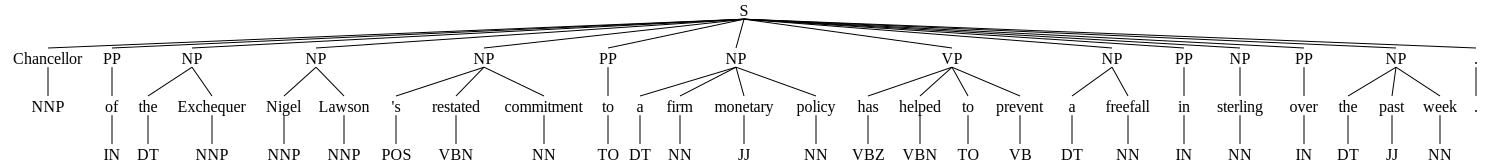

In [14]:
from IPython.display import display

# Needs svgling. If needed
# pip install svgling
display(train_data[1])

In [15]:
# extact pos and chunk tags from sentences ignoring the word
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [ [(t, c) for (w, t, c) in sent] for sent in tagged_sents]

# Trains multiple taggers with backoff taggers
# New to me, this concept of how nlkt etc use taggers and backoff taggers!
def combined_tagger(train_data, taggers, backoff = None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

In [16]:
%%mermaid_magic -h 500

---
title: Taggers
---
classDiagram    
    NGramTagger <|-- UnigramTagger
    NGramTagger <|-- BigramTagger
    NGramTagger <|-- TrigramTagger
    ContextTagger <|-- NGramTagger
    SequentialBackoffTagger <|-- ContextTagger    

In [17]:
from nltk.tag   import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):

    # train_sentences: A nltk Tree
    def __init__(self, train_sentences, tagger_classes = [UnigramTagger, BigramTagger]):
        train_sent_tags = conll_tag_chunks(train_sentences)
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

    
    def parse(self, tagged_sentence):
        if not tagged_sentence:
            return None

        pos_tags       = [tag for word, tag in tagged_sentence]
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags     = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        wpc_tags       = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag) in zip(tagged_sentence, chunk_tags)]
        
        return conlltags2tree(wpc_tags)

# train chunker model
ntc = NGramTagChunker(train_data)

# evaluate model on test data
# Sarkar used evaluate(test_data) but that is now deprecated
print(ntc.accuracy(gold=test_data))
                     

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


This gets an accuacy of 90% _(No change between 2018 and 2023 which shows that the underlying model hasn't changed or improved any)_. Test this on the sample news article

In [18]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Challenge/NNP)
  (VP is/VBZ)
  (NP on:/JJ Tech/NNP Mahindra/NNP CEO/NNP)
  (PP after/IN)
  (NP OpenAI/NNP CEO's/NNP)
  (NP 'hopeless'/POS remark/NN)
  (PP for/IN)
  (NP India/NNP))


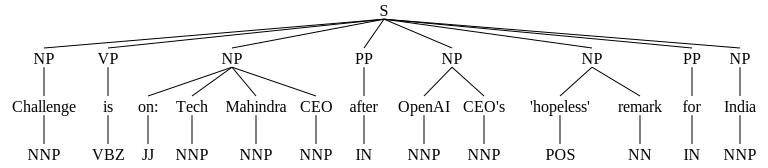

In [19]:
display(chunk_tree)

From the above analysis, you can see it detect

 Chunk Tag | Text 
 --- | --- 
 Noun Phrase | Twitter(NN) Spaces(NNP) team(NN)
 `down` | ??
 Verb Phrase | to(TO) roughly(VB)
 Noun Phrase | 3(CD) employees(NNS)
 Prepositional Phrase | from(IN)
 Noun Phrase | 100:(CD) Report(NN)

# Constituency Parsing

Constituent-based grammars _(like an actual parser generator grammar)_ are used to analyze sentences and determine their constituent parts. These grammars model the structure of the sentence in terms of a heirarchy of their constituent parts.
 - each word belongs to a specific category and forms the head word of different phrases _(each word is a head ??)_
 - the phrases are formed based on rules called _phrase structure rules_ which form the core of the constituency grammars. They determine
   - what words are used to construct the phrases or constituents
   - how the constituents are ordered
   - generic representation is $S \rightarrow AB$ represents a structure $S$ which consists of two constituents $A$ and $B$ in that order. $S \rightarrow NP VP$ signifies a sentence which is built from a _Noun Phrase(NP)_ followed by a _Verb Phrase(VP)_.

## Stanford NLP references
His examples use the `StanfordParser` java libs. `StanfordParser` is a PCFG parser _(Probabilistic Context Free Grammar)_ where it holds multiple possible structures in memory while parsing a sentence and picks the highest probability one at the end.

> Some requests online for something alternative to StanforParser as it always has a deterministic output even when sentence is ambiguous. One of the responses was to look at http://maltparser.org. Not sure if there is a way to tweak StanfordNLP itself.
>
> Also StanfordNLP is now (2023) part of the `stanza` package which needs to be installed via `mamba install -c stanfordnlp stanza`. It seems to still use java. If it works out, it will be simpler to use it from scala.

The code in the article was as follows
```python
# set java path
import os
java_path = r'C:\Program Files\Java\jdk1.8.0_102\bin\java.exe'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')
                   
result = list(scp.raw_parse(ce))`
print
```

## Upgrade example to stanza

Stanza related information has been moved to [NLP_StanfordCoreNLP_Stanza.ipynb](./NLP_StanfordCoreNLP_Stanza.ipynb)

In [20]:
# one time download of english language model. There are many other models
# These are saved under ~/stanza_resources
# import stanza
# stanza.download('en')

In [21]:
import stanza
stanza_nlp = stanza.Pipeline('en')  # Setup a neural pipeline in english
doc = stanza_nlp(str(news_df.iloc[1].news_headline))
doc.sentences[0].print_dependencies()

2023-06-14 22:55:38 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-14 22:55:39 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

2023-06-14 22:55:39 INFO: Using device: cuda
2023-06-14 22:55:39 INFO: Loading: tokenize
2023-06-14 22:55:40 INFO: Loading: pos
2023-06-14 22:55:40 INFO: Loading: lemma
2023-06-14 22:55:40 INFO: Loading: constituency
2023-06-14 22:55:41 INFO: Loading: depparse
2023-06-14 22:55:41 INFO: Loading: sentiment
2023-06-14 22:55:41 INFO: Loading: ner
2023-06-14 22:55:41 INFO: Done loading processors!


('Challenge', 3, 'nsubj')
('is', 3, 'cop')
('on', 0, 'root')
(':', 7, 'punct')
('Tech', 7, 'compound')
('Mahindra', 7, 'compound')
('CEO', 3, 'parataxis')
('after', 14, 'case')
('OpenAI', 10, 'compound')
("CEO's", 14, 'nmod:poss')
("'", 10, 'case')
('hopeless', 14, 'amod')
("'", 14, 'punct')
('remark', 7, 'nmod')
('for', 16, 'case')
('India', 14, 'nmod')


# Dependency parsing

Dependency parsing adds to annotation of a constituency parsning by also including semantic dependency information. The basic principle is that

> In any sentence, all words except one have some relationship or dependency on other words in the setence. The word that has no dependency is called the **root word**. The verb is taken as the root of the sentence in most cases. All other sentence words are directly or indirectly linked to the root verb using **links** which are the dependencies.

 - All words _except one_ in a sentence are dependent on other words
 - The word that is not dependent on any is called the **root word**
 - The verb is usually the root _(when is it not ?)_
 - The links form the semantic dependencies

## Universal dependencies

The dependency parse diagrams do not use the penn-treebank tags. They use a more moden set of tags which are generalized to apply to multiple languages (_not just english_). See
 - Dependeny list reference at [Universal dependencies relationships](https://universaldependencies.org/u/dep/index.html)
 - There are **37** basic universal dependencies
 - Each language can define additional subtypes of one of the 37 basic ones. Such subtypes are prefixed with the basic type. For instance `aux:pass` is a `passive auxiliary` which is a sub-type of `aux`.
   - Some subtypes apply to many language
 - There are also [enhanced dependencies](https://universaldependencies.org/u/overview/enhanced-syntax.html) for additional complex dependency representation.

> At this point, we are getting deep into linguistics without a solid grounding in it. Totally a case for having an expert advisor or partner on board.


## Spacy and dependencies

> Online forums suggest that spacy is much faster than StanfordNLP for some tasks. Need to time it and figure out.

In [31]:
# Print each link separately
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---Challenge[nsubj]--->['CEO']
--------
['Challenge']<---is[ROOT]--->['on', ':', 'after']
--------
[]<---on[prep]--->[]
--------
[]<---:[punct]--->[]
--------
[]<---Tech[compound]--->[]
--------
['Tech']<---Mahindra[compound]--->[]
--------
['Mahindra']<---CEO[appos]--->[]
--------
[]<---after[prep]--->['remark']
--------
[]<---OpenAI[compound]--->[]
--------
['OpenAI']<---CEO[poss]--->["'s"]
--------
[]<---'s[case]--->[]
--------
[]<---'[punct]--->[]
--------
[]<---hopeless[amod]--->[]
--------
[]<---'[punct]--->[]
--------
['CEO', "'", 'hopeless', "'"]<---remark[pobj]--->['for']
--------
[]<---for[prep]--->['India']
--------
[]<---India[pobj]--->[]
--------



## Stanza and dependencies

> Anything beyond the standard dependencies needs Java and the coreNLP package to be installed
>
> use `stanza.install_corenlp()` which installs it into `~/stanza_corenlp`

### The different kinds of dependencies

The Stanza Python API by default only supports `standard Universal Dependencies`. The CoreNLP server product _(java)_ however supports multiple types of universal dependencies (all through the same `depparse` module that is used by stanza)
 - BasicDependenciesAnnotation
   - _(aka basic)_ - just the 37 standard UD dependencies
   - Easy to parse, small set
 - EnhancedDependenciesAnnotation : _(aka enhanced)_
   - From the JSON response, this is **likely** available under the `sentence[enhancedDependencies]` key.
 - EnhancedPlusPlusDependenciesAnnotation : _(aka enhanced++)_
   - From the JSON response, this is available under the `sentence[enhancedPlusPlusDependencies]` key.
   - I heard about this from [coreNLP Dtree Visualizer](https://github.com/doug919/corenlp_dtree_visualizer) which converts the CoreNLP dependency tree into a format that can be visualized by spacy!.
   - Deterministic transformations on the basic dependencies
   - Lot more semantic information

```python
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma,depparse')
with ud_enhancer.UniversalEnhancer(language="en") as enhancer:
    depparseFromStanza = nlp("This is a test")
    depparseEnhanced = enhancer.process(depparseFromStanza)
)
```

In [22]:
doc.sentences[0].print_dependencies()

('Challenge', 3, 'nsubj')
('is', 3, 'cop')
('on', 0, 'root')
(':', 7, 'punct')
('Tech', 7, 'compound')
('Mahindra', 7, 'compound')
('CEO', 3, 'parataxis')
('after', 14, 'case')
('OpenAI', 10, 'compound')
("CEO's", 14, 'nmod:poss')
("'", 10, 'case')
('hopeless', 14, 'amod')
("'", 14, 'punct')
('remark', 7, 'nmod')
('for', 16, 'case')
('India', 14, 'nmod')


In [25]:
# Ref: https://github.com/stanfordnlp/stanza/issues/359
# To get enhanced stanza dependencies. This is one way
# Needs the StanfordCoreNLP java process to be running
import stanza.server.ud_enhancer as ud_enhancer
# ud_enhancer.process_doc(doc, language="en")

In [26]:
# Ref: https://github.com/stanfordnlp/stanza/issues/359
enh_ud_nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma,depparse')
with ud_enhancer.UniversalEnhancer(language="en") as enhancer:
    depparseFromStanza = enh_ud_nlp("John said that he loved mila")
    depparseEnhanced = enhancer.process(depparseFromStanza)

2023-06-14 22:56:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-14 22:56:06 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-06-14 22:56:06 INFO: Using device: cuda
2023-06-14 22:56:06 INFO: Loading: tokenize
2023-06-14 22:56:06 INFO: Loading: pos
2023-06-14 22:56:07 INFO: Loading: lemma
2023-06-14 22:56:07 INFO: Loading: depparse
2023-06-14 22:56:07 INFO: Done loading processors!


In [30]:
# This gets the enhancedPlusPludDependencies
#print(depparseEnhanced.sentence[0].enhancedPlusPlusDependencies)

from hillops.nlp.viz import get_displaycy_from_stanza_dependencies
tree = get_displaycy_from_stanza_dependencies(
    depparseEnhanced.sentence[0].token,
    depparseEnhanced.sentence[0].enhancedPlusPlusDependencies)

displacy.render(tree, style="dep", manual=True)